In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from prefect.blocks.system import Secret
from catnip.fla_redshift import FLA_Redshift
from typing import Dict
from concurrent.futures import ThreadPoolExecutor
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

In [ ]:
# x = days out until game, but each game has a unique number of days until game, so run model 42 times?
# 

In [8]:
x = 'D'
q = """
select *
from custom.cth_game_descriptions
where season = '2023-24'
and tier = '{}'
""".format(x)
q = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)
q

,event_date,season,abbreviation,full_opponent,start_time,start_time_tableau,event_datetime,event_datetime_utc,day_of_week,tier,...,is_dense,is_holiday,is_conf,div,original_six_plus_extra,overall_points_percentage,home_rolling_points_percentage,opp_pp_3_seasons,theme_night_var,processed_date
0,2023-11-12,2023-24,CHI,Chicago Blackhawks,1:00 PM,1 PM,2023-11-12 13:00:00,2023-11-12 18:00:00+00:00,Sun,D,...,0,0,0,3,1.00,0.0,0.0,47.33,False,2024-06-03 17:34:06.556900+00:00
1,2024-01-17,2023-24,DET,Detroit Red Wings,7:00 PM,7 PM,2024-01-17 19:00:00,2024-01-18 00:00:00+00:00,Wed,D,...,1,0,1,1,0.75,0.0,0.0,38.50,False,2024-06-03 17:34:06.556900+00:00
2,2024-02-08,2023-24,WSH,Washington Capitals,7:00 PM,7 PM,2024-02-08 19:00:00,2024-02-09 00:00:00+00:00,Thu,D,...,1,0,1,2,0.75,0.0,0.0,65.00,False,2024-06-03 17:34:06.556900+00:00
3,2023-10-21,2023-24,VAN,Vancouver Canucks,7:00 PM,7 PM,2023-10-21 19:00:00,2023-10-21 23:00:00+00:00,Sat,D,...,1,0,0,4,0.00,0.0,0.0,52.40,True,2024-06-03 17:34:06.556900+00:00
4,2023-11-10,2023-24,CAR,Carolina Hurricanes,7:00 PM,7 PM,2023-11-10 19:00:00,2023-11-11 00:00:00+00:00,Fri,D,...,0,0,1,2,0.00,0.0,0.0,67.23,True,2024-06-03 17:34:06.556900+00:00
5,2023-11-20,2023-24,EDM,Edmonton Oilers,7:00 PM,7 PM,2023-11-20 19:00:00,2023-11-21 00:00:00+00:00,Mon,D,...,0,1,0,4,0.00,0.0,0.0,62.07,True,2024-06-03 17:34:06.556900+00:00
6,2024-01-15,2023-24,ANA,Anaheim Ducks,1:00 PM,1 PM,2024-01-15 13:00:00,2024-01-15 18:00:00+00:00,Mon,D,...,1,0,0,4,0.00,0.0,0.0,43.97,False,2024-06-03 17:34:06.556900+00:00
7,2024-02-06,2023-24,PHI,Philadelphia Flyers,7:00 PM,7 PM,2024-02-06 19:00:00,2024-02-07 00:00:00+00:00,Tue,D,...,0,0,1,2,1.00,0.0,0.0,51.17,False,2024-06-03 17:34:06.556900+00:00
8,2024-03-28,2023-24,NYI,New York Islanders,7:00 PM,7 PM,2024-03-28 19:00:00,2024-03-28 23:00:00+00:00,Thu,D,...,1,0,1,2,0.00,0.0,0.0,57.80,False,2024-06-03 17:34:06.556900+00:00
9,2024-04-09,2023-24,OTT,Ottawa Senators,7:00 PM,7 PM,2024-04-09 19:00:00,2024-04-09 23:00:00+00:00,Tue,D,...,0,0,1,1,0.00,0.0,0.0,44.57,False,2024-06-03 17:34:06.556900+00:00


In [3]:
q = """
    with seats as
        (select
            distinct seat_id, pc_one, row_name, seat
        from
            custom.cth_manifest_2223 ),
    dates as
        (select
            event_date
        from
            custom.cth_game_descriptions
        where
            season = '2022-23' and game_type = 1),
    other as
        (select
            date(event_date) as event_date, section_name,
            cast(section_name as varchar)+'-'+cast(row_name as varchar)+'-'+cast(seat as varchar) as seat_id, gross_revenue, ticket_type
        from
            custom.cth_historical_all_1718_2223
        where
            season = '2022-23'),
    base as
        (select
            *
        from
            dates
        cross
            join seats)
    select
        base.event_date, tier, is_premier::int, original_six_plus_extra, base.seat_id, abbreviation, pc_one, row_name, seat,
            CASE
                WHEN pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8')
                    THEN 'Lowers'
                WHEN pc_one in ('K', 'L', 'M') THEN 'Clubs'
                WHEN pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T') THEN 'Uppers'
                WHEN pc_one in ('U', 'V', 'W') THEN 'Suites'
                WHEN pc_one in ('X') THEN 'Amerant'
                WHEN pc_one in ('Y') THEN 'Loft'
                WHEN pc_one in ('Z') THEN 'Corona'
                ELSE 'unknown'
                END AS location,
        CASE
            when gross_revenue > 0 then gross_revenue
            else 0
        end as block_purchase_price,
        CASE
            when ticket_type IS NOT NULL then ticket_type
            else 'Not Sold'
        end as ticket_type_final,
        CASE
            when ticket_type_final in ('Full', 'Annual Suites', 'Premier', 'Flex', 'Quarter', 'Sponsor', 'Trade') then 'Plans'
            when ticket_type_final in ('Not Sold') then 'Not Sold'
            else 'Nightly'
        end as ticket_type_group
    from
        base
    left join
        other on base.event_date = other.event_date and base.seat_id = other.seat_id
    left join
        custom.cth_game_descriptions on base.event_date = cth_game_descriptions.event_date
    order by
        base.event_date, base.seat_id
    """

df_2223 = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [4]:
df_2223

,event_date,tier,is_premier,original_six_plus_extra,seat_id,abbreviation,pc_one,row_name,seat,location,block_purchase_price,ticket_type_final,ticket_type_group
0,2022-10-19,C,1,0.75,101-10-1,PHI,X,10,1,Amerant,236.25,Full,Plans
1,2022-10-19,C,1,0.75,101-10-10,PHI,X,10,10,Amerant,236.25,Full,Plans
2,2022-10-19,C,1,0.75,101-10-11,PHI,X,10,11,Amerant,236.25,Full,Plans
3,2022-10-19,C,1,0.75,101-10-12,PHI,X,10,12,Amerant,236.25,Full,Plans
4,2022-10-19,C,1,0.75,101-10-13,PHI,X,10,13,Amerant,236.25,Full,Plans
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817986,2023-04-13,D,1,0.00,SL50-SRO-3,CAR,W,SRO,3,Suites,63.21,Annual Suites,Plans
817987,2023-04-13,D,1,0.00,SL50-SRO-4,CAR,W,SRO,4,Suites,63.21,Annual Suites,Plans
817988,2023-04-13,D,1,0.00,SL50-SRO-5,CAR,W,SRO,5,Suites,63.21,Annual Suites,Plans
817989,2023-04-13,D,1,0.00,SL50-SRO-6,CAR,W,SRO,6,Suites,0.00,Not Sold,Not Sold


In [14]:
df_2223['dow'] = [datetime.weekday(datetime.strptime(x, "%Y-%m-%d")) for x in df_2223['event_date']]
df_2223['tier_num'] = [5 if tier == 'A' else (4 if tier == 'B' else (3 if tier == 'C' else (2 if tier == 'D' else 1))) for tier in df_2223['tier']]
df_2223['random'] = [x for x in (np.random.rand(len(df_2223),1)/2)]

pcs = sorted(df_2223['pc_one'].unique())
pc_dict = dict((value,count) for count, value in enumerate(pcs))
df_2223['pc_num'] = df_2223.apply(lambda row: pc_dict[row['pc_one']], axis = 1)
df_2223 = df_2223.sample(n=len(df_2223), random_state=1993)
df_2223 = df_2223.reset_index()

# rows = sorted(df_2223['row_name'].unique())
# pc_dict = dict((value,count) for count, value in enumerate(rows))
# df_2223['rows_num'] = df_2223.apply(lambda row: pc_dict[row['row_name']], axis = 1)
# df_2223 = df_2223.sample(n=len(df_2223), random_state=1993)
# df_2223 = df_2223.reset_index()

X = df_2223[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra']]
y = df_2223[['ticket_type_group']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1993, shuffle=False, stratify=None)
ss = StandardScaler()
x_train_scaled = ss.fit_transform(X_train)
x_test_scaled = ss.fit_transform(X_test)

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.6190751624386692


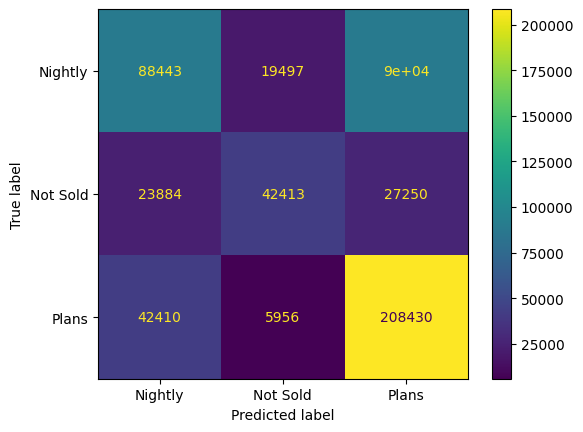

In [13]:
# RFC
clf = RandomForestClassifier(random_state = 1993)
clf.fit(x_train_scaled, y_train)

predicted = clf.predict(x_train_scaled)
cm = confusion_matrix(y_train.values,predicted, labels = ['Nightly', 'Not Sold', 'Plans'])
print(accuracy_score(y_train.values,predicted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nightly','Not Sold', 'Plans'])
disp.plot()
plt.show()

In [16]:
df1 = pd.DataFrame(data = df_2223[0:736191])
df2 = pd.DataFrame(data = predicted, columns = ['predicted'])
df3 = pd.DataFrame(data = clf.predict_proba(x_train_scaled), columns = ['Nightly', 'Not Sold', 'Plans'])
#df1 = pd.concat([df1, y_train], axis = 1).reset_index(drop = True)
df1 = pd.concat([df1, df2, df3], axis = 1)
#df1 = df1.merge(right = tier_full, how = 'left', on = 'tier')
# df1 = df1[df1['ticket_type_group'] != 'Not Sold']
# df1 = df1[df1['event_date'] == '2022-11-23']
print(Counter(df1['predicted'].tolist()).keys())
print(Counter(df1['predicted'].tolist()).values())

dict_keys(['Plans', 'Nightly', 'Not Sold', nan])
dict_values([325450, 154737, 67866, 188138])


In [15]:
q = """
with seats as
    (select
        distinct seat_id, pc_one
    from
        custom.cth_manifest_2223 ),
dates as
    (select
        event_date
    from
        custom.cth_game_descriptions
    where
        season = '2023-24' and game_type = 1),
other as
    (select
        date(event_datetime) as event_date
            , section, row, seat,
        cast(section as varchar)+'-'+cast(row as varchar)+'-'+cast(seat as varchar) as seat_id, gross_revenue, ticket_type
    from
        custom.cth_v_ticket_2324),
base as
    (select
        *
    from
        dates
    cross
        join seats)
select
    base.event_date, tier, is_premier::int, original_six_plus_extra, base.seat_id, abbreviation, pc_one,
        CASE
            WHEN pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8')
            THEN 'Lowers'
            WHEN pc_one in ('K', 'L', 'M') THEN 'Clubs'
            WHEN pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T') THEN 'Uppers'
            WHEN pc_one in ('U', 'V', 'W') THEN 'Suites'
            WHEN pc_one in ('X') THEN 'Amerant'
            WHEN pc_one in ('Y') THEN 'Loft'
            WHEN pc_one in ('Z') THEN 'Corona'
            ELSE 'unknown'
            END AS location,
    CASE
        when gross_revenue > 0 then gross_revenue
        else 0
    end as block_purchase_price,
    CASE
        when ticket_type IS NOT NULL then ticket_type
        else 'Not Sold'
    end as ticket_type_final,
    CASE
        when ticket_type_final in ('Full', 'Annual Suites', 'Premier', 'Flex', 'Quarter', 'Sponsor', 'Trade') then 'Plans'
        when ticket_type_final in ('Not Sold') then 'Not Sold'
        else 'Nightly'
    end as ticket_type_group
from
    base
left join
    other on base.event_date = other.event_date and base.seat_id = other.seat_id
left join
    custom.cth_game_descriptions on base.event_date = cth_game_descriptions.event_date
order by
    base.event_date, base.seat_id
    """

df_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [148]:
df_2324['dow'] = [datetime.weekday(datetime.strptime(x, "%Y-%m-%d")) for x in df_2324['event_date']]
df_2324['tier_num'] = df_2324.apply(lambda row: 5 if row['tier'] == 'A' else (4 if row['tier'] == 'B' else (3 if row['tier'] == 'C' else (2 if row['tier'] == 'D' else 1))), axis = 1)
df_2324['random'] = [x for x in (np.random.rand(len(df_2324),1)/2)]

pcs = sorted(df_2324['pc_one'].unique())
pc_dict = dict((value,count) for count, value in enumerate(pcs))
df_2324['pc_num'] = df_2324.apply(lambda row: pc_dict[row['pc_one']], axis = 1)
# df_2324 = df_2324.sample(n=len(df_2324), random_state=1993)
# df_2324 = df_2324.reset_index()

In [149]:
X = df_2324[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra', 'random']]
X = ss.fit_transform(X)
y = df_2324[['ticket_type_group']]

predicted = clf.predict(X)

In [150]:
q = """
with a as
    (select cth_ticket_expanded_all.event_date, tier, count(*), (1.0*count(*)/6057)-1 as diff
    from custom.cth_ticket_expanded_all
    left join custom.cth_game_descriptions on cth_ticket_expanded_all.event_date = cast(date(cth_game_descriptions.event_date) as VARCHAR)
    where ticket_type = 'Full'
    group by cth_ticket_expanded_all.event_date, tier
    order by cth_ticket_expanded_all.event_date)
select tier, avg(diff)
from a
group by tier
order by tier"""

tier_full = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [167]:
tier_full

,tier,avg
0,A,0.045979
1,B,0.026772
2,C,0.005483
3,D,-0.004194
4,E,-0.015538
5,PS,-0.033020


In [151]:
df2 = pd.DataFrame(data = predicted, columns = ['predicted'])
df3 = pd.DataFrame(data = clf.predict_proba(X), columns = ['Nightly', 'Not Sold', 'Plans'])
df_final = pd.concat([df_2324,df2,df3], axis = 1)

In [166]:
df_final

,event_date,tier,is_premier,original_six_plus_extra,seat_id,abbreviation,pc_one,location,block_purchase_price,ticket_type_final,...,dow,tier_num,random,pc_num,predicted,Nightly,Not Sold,Plans,actual_plan_add,others_add
0,2023-10-07,E,0,1.5,101-10-1,TBL,X,Amerant,155.76,Full,...,5,1,[0.0003214641342402236],31,Plans,0.09,0.03,0.88,0,3206
1,2023-10-07,E,0,1.5,101-10-10,TBL,X,Amerant,168.27,Full,...,5,1,[0.46210134164443023],31,Plans,0.06,0.00,0.94,0,3206
2,2023-10-07,E,0,1.5,101-10-11,TBL,X,Amerant,168.27,Full,...,5,1,[0.2916032730110595],31,Plans,0.08,0.00,0.92,0,3206
3,2023-10-07,E,0,1.5,101-10-12,TBL,X,Amerant,168.27,Full,...,5,1,[0.27870487859626153],31,Plans,0.06,0.00,0.94,0,3206
4,2023-10-07,E,0,1.5,101-10-13,TBL,X,Amerant,155.76,Full,...,5,1,[0.26394964764137374],31,Plans,0.11,0.02,0.87,0,3206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837937,2024-04-16,B,1,1.0,SL50-SRO-3,TOR,W,Suites,0.00,Not Sold,...,1,4,[0.23130875796397687],30,Plans,0.19,0.05,0.76,307,1322
837938,2024-04-16,B,1,1.0,SL50-SRO-4,TOR,W,Suites,0.00,Not Sold,...,1,4,[0.016177724892240453],30,Plans,0.35,0.23,0.42,307,1322
837939,2024-04-16,B,1,1.0,SL50-SRO-5,TOR,W,Suites,0.00,Not Sold,...,1,4,[0.09107689905898153],30,Nightly,0.72,0.01,0.27,307,1322
837940,2024-04-16,B,1,1.0,SL50-SRO-6,TOR,W,Suites,0.00,Not Sold,...,1,4,[0.14948501157267108],30,Nightly,0.44,0.39,0.17,307,1322


In [152]:
df_final_not_sold = df_final[df_final['ticket_type_group'] == 'Not Sold']
df_final_not_sold = df_final_not_sold.groupby(by = ['event_date', 'tier','predicted'])['seat_id'].count()
df_final_not_sold = df_final_not_sold.to_frame()
df_final_not_sold.reset_index(inplace = True)
df_final_not_sold = df_final_not_sold.merge(right = tier_full, how = 'left', on = 'tier')
df_final_not_sold.rename(columns = {"predicted":"ticket_type","seat_id":"additional"}, inplace = True)

df_final_sold = df_final[df_final['ticket_type_group'] != 'Not Sold']
df_final_sold = df_final_sold.groupby(by = ['event_date', 'tier','ticket_type_group'])['seat_id'].count()
df_final_sold = df_final_sold.to_frame()
df_final_sold.reset_index(inplace = True)
df_final_sold.rename(columns = {"ticket_type_group":"ticket_type","seat_id":"actual"}, inplace = True)

df_final_final = df_final_not_sold.merge(right = df_final_sold, how = 'left', on = ['event_date', 'tier','ticket_type'])
df_final_final['plans_add'] = df_final_final.apply(lambda row: 0 if row['ticket_type'] != 'Plans' else (int(float(row['actual'])*float(row['avg'])) if float(row['actual'])*float(row['avg']) > 0 else 0), axis = 1)
df_final_final['days_out'] = df_final_final.apply(lambda row: float((datetime.strptime(row['event_date'], '%Y-%m-%d').date()-date.today()).days), axis = 1)

In [153]:
dist_df = pd.read_csv("C:\\Users\\riffere\\Desktop\\plan_addon_distribution.csv")

In [154]:
df_final_final = df_final_final.merge(right = dist_df, how = 'left', on = 'days_out')
df_final_final['actual_plan_add'] = [int((1-x)*y) for x,y in zip(df_final_final['percent_in'],df_final_final['plans_add'])]

In [155]:
df_final_final['others_add'] = [x-y for x,y in zip(df_final_final['additional'],df_final_final['actual_plan_add'])]
merge_df = df_final_final[df_final_final['ticket_type'] == 'Plans'][['event_date','actual_plan_add','others_add']]

In [156]:
df_final = df_final.merge(right = merge_df, how = 'left', on = 'event_date')

In [157]:
df_final_not_sold = df_final[df_final['ticket_type_final'] == 'Not Sold']

In [158]:
df_final_not_sold['rank'] = df_final_not_sold.groupby(by = 'event_date')['Plans'].rank(ascending = False)
df_final_not_sold['predicted_final'] = df_final_not_sold.apply(lambda row: 'Plans' if row['predicted'] == 'Plans' and row['rank'] <= row['actual_plan_add'] else 
                                             ('Nightly' if row['predicted'] == 'Nightly' or row['Nightly'] > row['Not Sold'] else 'Not Sold'), axis = 1)

C:\Users\riffere\AppData\Local\Temp\ipykernel_15288\2962138116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_not_sold['rank'] = df_final_not_sold.groupby(by = 'event_date')['Plans'].rank(ascending = False)
C:\Users\riffere\AppData\Local\Temp\ipykernel_15288\2962138116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_not_sold['predicted_final'] = df_final_not_sold.apply(lambda row: 'Plans' if row['predicted'] == 'Plans' and row['rank'] <= row['actual_plan_add'] else


In [159]:
df_final_not_sold = df_final_not_sold.groupby(by = ['event_date','predicted_final'])['random'].count()
df_final_not_sold = df_final_not_sold.to_frame()
df_final_not_sold.reset_index(inplace = True)

df_final_sold = df_final[df_final['ticket_type_final'] != 'Not Sold']
df_final_sold = df_final_sold.groupby(by = ['event_date','ticket_type_group'])['random'].count()
df_final_sold = df_final_sold.to_frame()
df_final_sold.reset_index(inplace = True)

In [160]:
df_final_not_sold.rename(columns = {'predicted_final':'ticket_type_group','random':'predicted_additional_tickets'}, inplace=True)
df_final_sold.rename(columns = {'random':'current_tickets'}, inplace=True)

In [162]:
df = df_final.groupby(by = ['event_date', 'ticket_type_group'])['random'].sum()
df = df.to_frame()
df.reset_index(inplace = True)
df = df[['event_date', 'ticket_type_group']]

In [163]:
df = df.merge(right = df_final_sold, how = 'left', on = ['event_date', 'ticket_type_group'])
df = df.merge(right = df_final_not_sold, how = 'left', on = ['event_date', 'ticket_type_group'])
df

,event_date,ticket_type_group,current_tickets,predicted_additional_tickets
0,2023-10-07,Nightly,3200.0,4973.0
1,2023-10-07,Not Sold,NaN,3176.0
2,2023-10-07,Plans,8602.0,NaN
3,2023-10-19,Nightly,3592.0,2796.0
4,2023-10-19,Not Sold,NaN,1788.0
...,...,...,...,...
121,2024-04-13,Not Sold,NaN,2432.0
122,2024-04-13,Plans,11713.0,NaN
123,2024-04-16,Nightly,3107.0,2908.0
124,2024-04-16,Not Sold,NaN,1952.0


In [164]:
df.to_csv('C:\\Users\\riffere\\Desktop\\df.csv')